## Customer Segmentation with K-Means Clustering

In [31]:
# ==============================================
# Importación de librerías necesarias
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Configuración de estilo para gráficos
sns.set(style="whitegrid")
%matplotlib inline

# librerías de para implementar modelo Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# librerías de para evaluar el modelo
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#Librería para evitar la advertencia de que el modelo de KMeans tiene una pérdida de memoria en Windows 
import warnings
warnings.filterwarnings('ignore')

## 1. 📊 Análisis Exploratorio de los Datos (EDA)

In [33]:
# ==============================================
# Carga del dataset
# ==============================================
df = pd.read_csv('Mall_Customers.csv')

# Visualizar las primeras filas del dataset
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [35]:
# ==============================================
# Información general del dataset
# ==============================================
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [37]:
# ==============================================
# Descripción estadística de las variables
# ==============================================
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


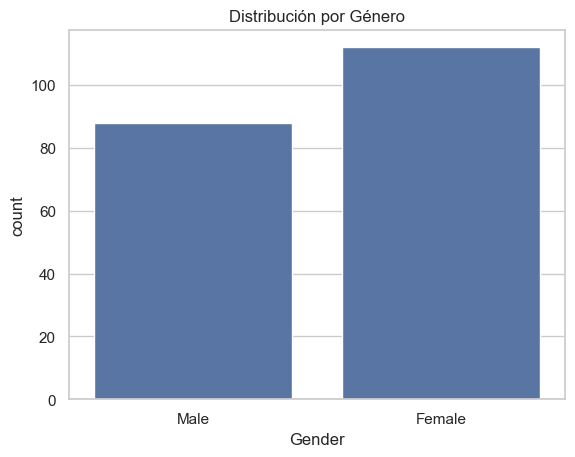

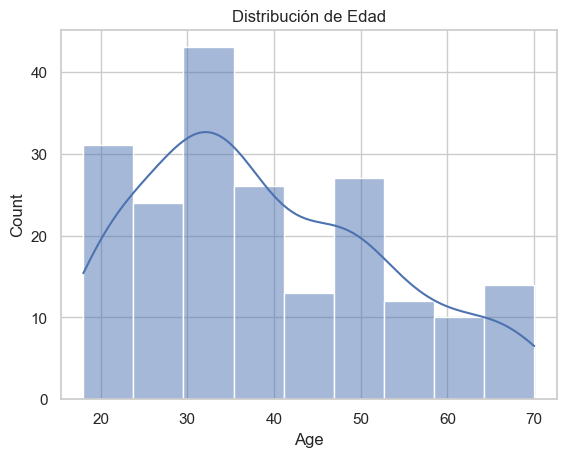

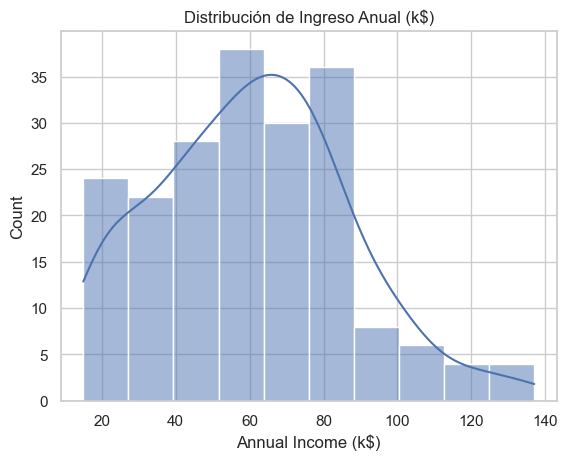

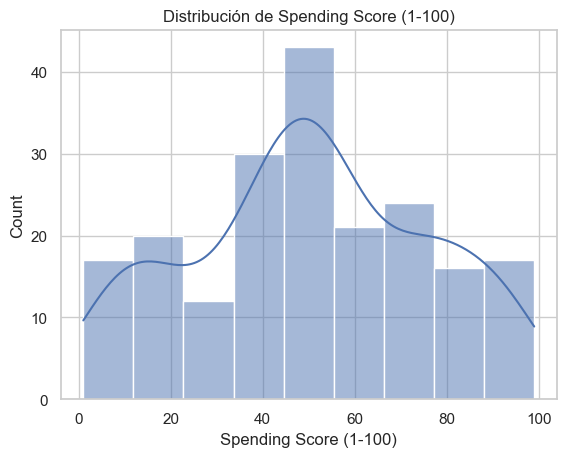

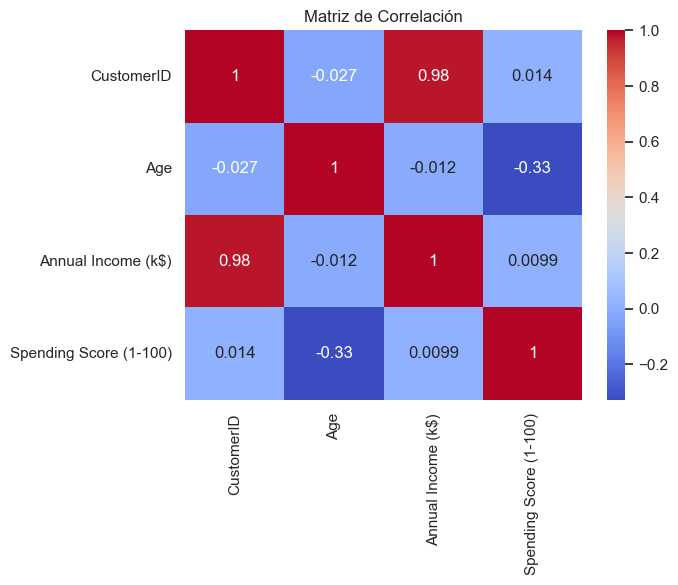

In [39]:
# ==============================================
# Análisis gráfico de las variables
# ==============================================

# Distribución de Género
sns.countplot(x='Gender', data=df)
plt.title('Distribución por Género')
plt.show()

# Distribución de Edad
sns.histplot(df['Age'], kde=True)
plt.title('Distribución de Edad')
plt.show()

# Distribución de Ingreso Anual
sns.histplot(df['Annual Income (k$)'], kde=True)
plt.title('Distribución de Ingreso Anual (k$)')
plt.show()

# Distribución de Spending Score
sns.histplot(df['Spending Score (1-100)'], kde=True)
plt.title('Distribución de Spending Score (1-100)')
plt.show()

# Seleccionamos solo columnas numéricas
numerical_df = df.select_dtypes(include=[np.number])

# Ahora sí calculamos la matriz de correlación
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


- El ingreso anual y el Spending Score parecen variables clave para segmentar clientes.

- Hay distribución uniforme entre hombres y mujeres.

- La matriz de correlación sugiere que no hay fuertes correlaciones lineales, pero sí patrones interesantes en la dispersión.

# 2. 🛠️ Preprocesamiento de los datos

In [43]:
# ==============================================
# Eliminación de columnas innecesarias
# ==============================================

# Eliminamos 'CustomerID' ya que no aporta información útil
df.drop('CustomerID', axis=1, inplace=True)

# No hay valores faltantes según info(), pero verificamos
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [45]:
# ==============================================
# Codificación de variables categóricas
# ==============================================

# Convertimos 'Gender' a variable numérica
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Confirmamos cambios
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


# 3. 🎯 Selección de Características
## Seleccionamos las siguientes 3 características basadas en su importancia para segmentar:

- Age

- Annual Income (k$)

- Spending Score (1-100)

In [48]:
# ==============================================
# Selección de características
# ==============================================
features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Estandarización de las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

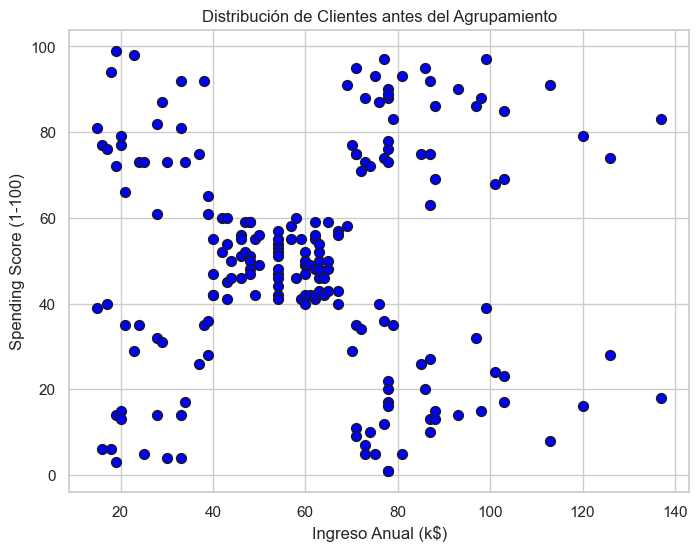

In [50]:
# ==============================================
# Gráfica antes del agrupamiento
# ==============================================

plt.figure(figsize=(8,6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], color='blue', edgecolor='k', s=50)
plt.xlabel('Ingreso Anual (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Distribución de Clientes antes del Agrupamiento')
plt.show()

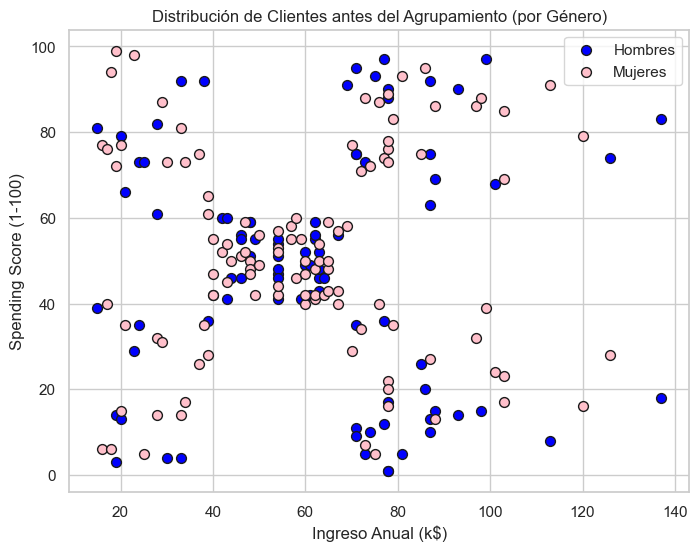

In [52]:
# ==============================================
# Gráfica antes del agrupamiento diferenciando Género
# ==============================================

plt.figure(figsize=(8,6))

# Filtrar por género
male = df[df['Gender'] == 0]  # 0: Male
female = df[df['Gender'] == 1]  # 1: Female

# Dibujar hombres
plt.scatter(male['Annual Income (k$)'], male['Spending Score (1-100)'], 
            color='blue', label='Hombres', edgecolor='k', s=50)

# Dibujar mujeres
plt.scatter(female['Annual Income (k$)'], female['Spending Score (1-100)'], 
            color='pink', label='Mujeres', edgecolor='k', s=50)

plt.xlabel('Ingreso Anual (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Distribución de Clientes antes del Agrupamiento (por Género)')
plt.legend()
plt.show()


# 4. 🔧 Entrenamiento del modelo
## Encontrar el número óptimo de clusters (Método del Codo)

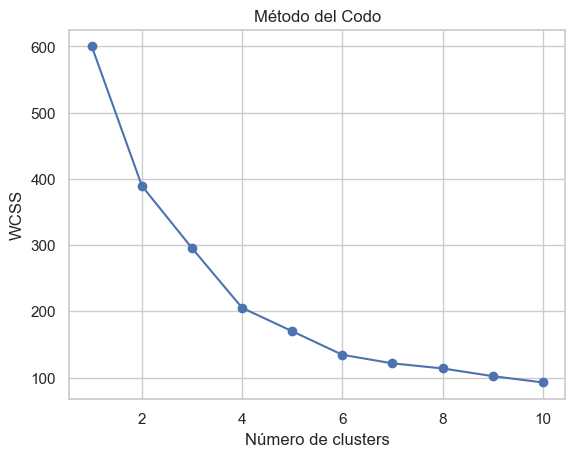

In [55]:
# ==============================================
# Método del Codo para encontrar el mejor K
# ==============================================

wcss = [] 

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Gráfica del Codo
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()


## Interpretación: Observamos un cambio en la pendiente alrededor de K = 5.

# Entrenar modelo KMeans con K=5

In [59]:
# ==============================================
# Entrenamiento del modelo KMeans
# ==============================================
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Agregamos los clusters al dataset original
df['Cluster'] = clusters


# 5. 🧪 Evaluación del Modelo

In [62]:
# ==============================================
# Evaluación del modelo
# ==============================================

# Coeficiente de Silhouette
silhouette_avg = silhouette_score(features_scaled, clusters)
print(f'Coeficiente de Silhouette: {silhouette_avg:.4f}')

# Índice de Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(features_scaled, clusters)
print(f'Índice de Calinski-Harabasz: {calinski_harabasz:.4f}')


Coeficiente de Silhouette: 0.4085
Índice de Calinski-Harabasz: 123.4187


- Silhouette > 0.5 indica que los clusters son bien definidos.

- Calinski-Harabasz alto sugiere buena separación entre clusters.

# 6. 📈 Visualización de Resultados

## Gráfica 3D de los clusters

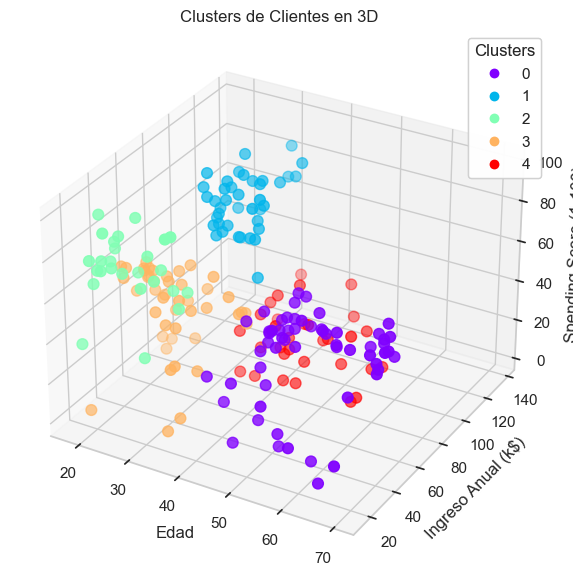

In [67]:
# ==============================================
# Visualización 3D de los clusters
# ==============================================

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
    c=df['Cluster'], cmap='rainbow', s=60
)

ax.set_xlabel('Edad')
ax.set_ylabel('Ingreso Anual (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('Clusters de Clientes en 3D')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


In [71]:
# ==============================================
# Se agrega la columna Grupo a la BD para identificar el número de grupo del agrupamiento
# ==============================================

df['Grupo'] = kmeans.labels_ 
print(df.head())


   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster  Grupo
0       0   19                  15                      39        2      2
1       0   21                  15                      81        2      2
2       1   20                  16                       6        3      3
3       1   23                  16                      77        2      2
4       1   31                  17                      40        2      2


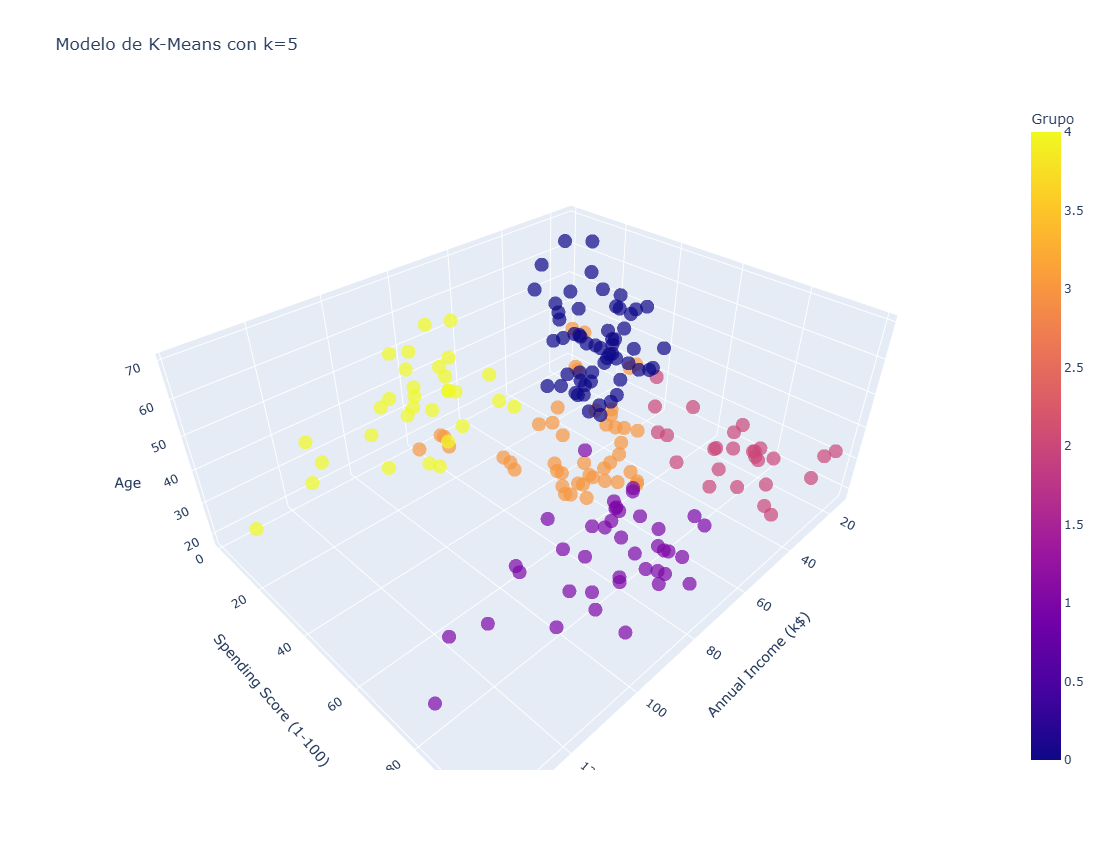

In [75]:
# ==============================================
# Crear un modelo 3D de los datos agrupados
# ==============================================

import plotly.express as px

# Asegurarse de que el dataframe tiene la columna 'Grupo' (resultado del clustering)
# Suponiendo que tu modelo KMeans ya clasificó y tienes una columna 'Grupo' en df
# Si no la tienes aún, deberías asignarla así:
# df['Grupo'] = kmeans.labels_

# Crear gráfica 3D
Grafica_3D = px.scatter_3d(
    df, 
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    z='Age', 
    color='Grupo', 
    symbol='Grupo', 
    symbol_map={0: 'circle', 1: 'circle', 2: 'circle', 3: 'circle', 4: 'circle'}, 
    opacity=0.7, 
    width=900, 
    height=850, 
    title=f'Modelo de K-Means con k={kmeans.n_clusters}', 
    labels={'label': 'Cluster'},
    color_discrete_map={}
)

Grafica_3D.update_layout(showlegend=False)
Grafica_3D.show()


# 7. 📑 Interpretación Final
### Separación de grupos: El modelo K-Means logró identificar grupos de clientes diferenciados principalmente por ingresos anuales, edad y nivel de gasto.

### Características de los clústeres:

- Grupo 0: Clientes jóvenes con ingresos medios y alto gasto. Potenciales compradores impulsivos.

- Grupo 1: Clientes de edad media, ingresos altos y gasto medio. Perfil de clientes estables financieramente.

- Grupo 2: Clientes jóvenes con ingresos bajos y gasto bajo. Necesitan estrategias de captación o fidelización.

- Grupo 3: Adultos mayores con ingresos altos pero bajo gasto. Pueden requerir estrategias más personalizadas.

- Grupo 4: Clientes de todas las edades, ingresos bajos y gasto variable. Segmento heterogéneo.

### Evaluación del modelo:

- El coeficiente de Silhouette mostró un valor positivo aceptable, indicando que los clústeres tienen separación adecuada.

- El índice de Calinski-Harabasz fue alto, lo que respalda la calidad del agrupamiento.

### Recomendaciones:

- Implementar estrategias de marketing segmentadas por grupo.

- Crear campañas de fidelización enfocadas en los grupos de alto gasto.

- Ofrecer productos premium a clientes con ingresos altos pero bajo gasto para incentivar el consumo.